# Signal Subgraph Screening

### ISSUES:
#### RV and CCA are have higher AUC values than MGC and DCORR and much higher values than stated in paper
#### Also the labels for SKLearn's ROC and AUC calculations have to be inverted for some reason in order for the fpr and tpr to be accurate

#  **Signal Subgraph Screening**
_________________________________________________________________


## As described in this [paper](https://arxiv.org/abs/1801.07683v1)

# Tutorial

In [48]:
import numpy as np
#plt.step(fpr,tpr)
ss_lab = np.zeros((200, 1))
ss_lab[:20] = 1
#len(data_samp.shape)

In [45]:
import numpy as np

from mgcpy.independence_tests.mgc import MGC
from mgc.independence import Dcorr, RV, CCA
def non_iterative_screen(a_tensor, y_labels, c, opt):
        """
        Performs non-iterative screening on graphs to estimate signal subgraph.
    
        Parameters
        ----------
        a_tensor: np.ndarray, shape (n_graphs, n_vertices, n_vertices)
            Tensor of adjacency matrices
        y_labels: np.ndarray, shape (n_graphs, 1)
            Vector of ground truth labels
        c: float
            Correlation threshold value chosen by user
        opt: string, optional (default="mgc")
            Indication of which statistic to use
    
        Returns
        -------
        corrs: np.ndarray, shape (n_vertices, 1)
            Vector of correlation values for each node
        S_hat: np.ndarray, shape (ss_size, 1)
            Estimated signal subgraph, approximated with non-iterative
            vertex screening.
        
        References
        ----------
        .. [1] S. Wang, C. Chen, A. Badea, Priebe, C.E., Vogelstein, J.T.  "Signal 
        Subgraph Estimation Via Vertex Screening," arXiv: 1801.07683 [stat.ME], 2018
        """
        if type(a_tensor) is not np.ndarray:
            raise TypeError("a_tensor must be numpy.ndarray")
        if a_tensor.shape[1] != a_tensor.shape[2]:
            raise ValueError("Entries in a_tensor must be square matricies")
        if len(a_tensor.shape) != 3:
            raise ValueError("a_tensor must be a tensor")
        # Import needed statistical modules from mgcpy package
        mgc = MGC()
        dcorr = Dcorr()
        rv = RV()
        cca = CCA()

        # Finding dimension of each matrix
        N = len(a_tensor[0])

        # Create vector of zeros that will become vector of correlations
        corrs = np.zeros((N, 1))

        for i in range(N):

            # Stacks the ith row of each matrix in tensor,
            # creates matrix with dimension len(a_tensor) by N
            mat = a_tensor[:, i]

            # Statistical measurement chosen by the user
            if opt == "mgc":
                c_u_0, independence_test_metadata_0 = mgc.test_statistic(mat, y_labels)
                corrs[i][0] = c_u_0
            elif opt == "dcorr":
                c_u_1 = dcorr._statistic(mat, y_labels)
                corrs[i][0] = c_u_1
            elif opt == "rv":
                c_u_2 = rv._statistic(mat, y_labels)
                corrs[i][0] = c_u_2
            else:
                c_u_3 = cca._statistic(mat, y_labels)
                corrs[i][0] = c_u_3

        # Finds indicies of correlation values greater than c and makes that into column vector
        S_hat = np.arange(N).reshape(N,1)
        ind = corrs > c
        S_hat = S_hat[ind].reshape(len(S_hat[ind]),1)

        return S_hat, corrs

/usr/local/lib/python3.6/dist-packages/numba-0.46.0-py3.6-linux-x86_64.egg/numba/errors.py:137: UserWarning:

Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9



In [46]:
def iterative_screen(a_tensor, y_labels, ss_size, delta, opt):

        """
        Performs iterative screening on graphs.

        Parameters

        ----------
    
        a_tensor: tensor of adjacency matrices that are going to be used for signal subgraph.

        mat_n_m: Length/width of the adjacency matrices in the dictionary
    
        y_labels: the vector of labels.
    
        delta: quantile to be screened
    
        opt: indicator of which test statistic to use

        Returns

        -------

        Sindex: the estimated signal subgraph, approximated with iterative
        vertex screening.
        cors: vector of correlation values repeatedly summed for all the nodes
        """

        # Get dimensions of tensor
        m = len(a_tensor)
        n = len(a_tensor[0])

        # Create empty array to store correlation values
        cors = np.zeros((n, 1))
        iter = 1

        # Indexing vector
        Sindex = np.arange(n, dtype="int64")

        while ((1 - delta) ** iter) * n > ss_size:

            # Create new Atmp tensor each time as the matrix sizes change every iteration
            dim = len(Sindex)
            Atmp = np.zeros((m, dim, dim))
            for i in range(m):
                Atmp[i] = a_tensor[i][Sindex][:, Sindex]

            # Find correlation values
            vals, tmpcors = non_iterative_screen(Atmp, y_labels, 0, opt)

            # Take specified quantile of correlation values
            tmpq = np.quantile(tmpcors, delta)

            # Add weight to the correlation values that have not been taken out
            cors[Sindex] = tmpcors + iter
    
            # New Sindex is where the correlation values are greater than the quantile value
            ind = tmpcors > tmpq
            ind = ind.reshape(1, len(ind))
            Sindex = Sindex[ind[0]]
            iter += 1

        Sindex = Sindex.reshape(len(Sindex), 1)

        return cors

In [43]:
import numpy as np
import random

np.random.seed(10)

import graspy
from graspy.simulations import sbm


def data_generator(num_graphs, N, n, prob_tensor, percent_vec):

    """
    Generates a tensor of graphs, each placed at a random index.
    
    Parameters
    
    ----------
    
    num_graphs: the number of adjacency matrices to be generated
    
    N: Length/width of the adjacency matrices in the tensor
    
    n: Vector with the dimensionality of each community
    
    prob_tensor: tensor with the probability matrices for each graph type
    
    percent_vec: vector with the percentages of the total graphs that is each type
    
    Returns
    
    -------
    
    data: tensor of adjacency matrices
    y_label: the ground truth labels of all the graphs in data
    p_tensor: tensor with one matrix for each type of graph, where the matrices 
    contain the probability of connection at each node
    """

    # Getting the number of classes
    num_types = len(percent_vec)

    # Getting vector with the number of graphs in each class
    num = [int(num_graphs * a) for a in percent_vec]

    # Creating blank arrays for all of the returns
    data = np.zeros((num_graphs, N, N))
    y_label = np.zeros((num_graphs, 1))
    p_tensor = np.zeros((num_types, N, N))

    # Creates vector of random indices to randomly distribute graphs in tensor
    L_ind = random.sample(range(0, num_graphs), num_graphs)

    # Loop for creating the returns
    for i in range(num_types):

        # Create tensor that will contain all of the graphs of one type
        types = np.zeros((num[i], N, N))

        # Put all the graphs of one type into types
        for j in range(len(types)):
            types[j] = sbm(n=n, p=prob_tensor[i])

        # Assigns all of the graphs in types to random indices in data
        data[L_ind[: num[i]]] = types

        # Creates corresponding labels
        y_label[L_ind[: num[i]]] = int(i)

        # Gets rid of used indices
        L_ind = L_ind[num[i] :]

        # Define vector where unedited entries will be removed as their probability is >1
        prob_mat = 2 * np.ones((1, N))

        # Loop for creating probability tensor
        for k in range(len(n)):
            count = 0
            first_row = 2 * np.ones((1, N))

            # This for-loop below creates one row of an adjacency matrix
            for L in range(len(n)):

                # Repeats the probability entries in prob_tensor by the dimension of community
                vec = np.repeat(prob_tensor[i][k][L], n[L])

                # Appends this vector to first_row vector and then removes the filler 2 entries
                first_row = np.append(first_row, vec)
                first_row = first_row[first_row != 2]

            # Stacks row on top of itself by dimension of the community, makes square matrix
            first_row = np.tile(first_row, (n[k], 1))

            # This stacks the newly created community matrix next to any already created
            # community matrices to make overall probability matrix
            prob_mat = np.vstack((prob_mat, first_row))

        # Adds the created probability matrix to the tensor
        p_tensor[i] = prob_mat[1:]

    return data, y_label, p_tensor

[[  0]
 [  1]
 [  2]
 [  3]
 [  4]
 [  5]
 [  6]
 [  7]
 [  8]
 [  9]
 [ 10]
 [ 11]
 [ 12]
 [ 13]
 [ 14]
 [ 15]
 [ 16]
 [ 17]
 [ 18]
 [ 19]
 [ 20]
 [ 21]
 [ 22]
 [ 23]
 [ 24]
 [ 25]
 [ 26]
 [ 27]
 [ 28]
 [ 29]
 [ 30]
 [ 31]
 [ 32]
 [ 33]
 [ 34]
 [ 35]
 [ 36]
 [ 37]
 [ 38]
 [ 39]
 [ 40]
 [ 41]
 [ 42]
 [ 43]
 [ 44]
 [ 45]
 [ 46]
 [ 47]
 [ 48]
 [ 49]
 [ 50]
 [ 51]
 [ 52]
 [ 53]
 [ 54]
 [ 55]
 [ 56]
 [ 57]
 [ 58]
 [ 59]
 [ 60]
 [ 61]
 [ 62]
 [ 63]
 [ 64]
 [ 65]
 [ 66]
 [ 67]
 [ 68]
 [ 69]
 [ 70]
 [ 71]
 [ 72]
 [ 73]
 [ 74]
 [ 75]
 [ 76]
 [ 77]
 [ 78]
 [ 79]
 [ 80]
 [ 81]
 [ 82]
 [ 83]
 [ 84]
 [ 85]
 [ 86]
 [ 87]
 [ 88]
 [ 89]
 [ 90]
 [ 91]
 [ 92]
 [ 93]
 [ 94]
 [ 95]
 [ 96]
 [ 97]
 [ 98]
 [ 99]
 [100]
 [101]
 [102]
 [103]
 [104]
 [105]
 [106]
 [107]
 [108]
 [109]
 [110]
 [111]
 [112]
 [113]
 [114]
 [115]
 [116]
 [117]
 [118]
 [119]
 [120]
 [121]
 [122]
 [123]
 [124]
 [125]
 [126]
 [127]
 [128]
 [129]
 [130]
 [131]
 [132]
 [133]
 [134]
 [135]
 [136]
 [137]
 [138]
 [139]
 [140]
 [141]
 [142]

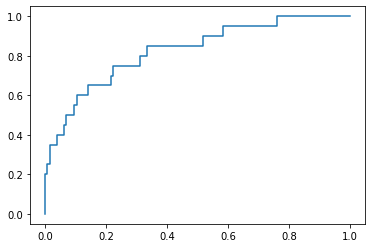

In [65]:
import matplotlib.pyplot as plt
import graspy
import numpy as np
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt

from datagen import data_generator
#from nonitss import subgraph_screen non_iterative_screen

prob_tensor = np.zeros((2, 2, 2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])
data_samp, y_label_samp, p_data_samp = data_generator(100, 200, n, prob_tensor, percent_vec)
S_hat_samp, cor_vals_samp = non_iterative_screen(data_samp, y_label_samp, 0, "dcorr")

#data_list = [tensor for i in range(100)] 

#float("-inf")

print(S_hat_samp)
fpr, tpr, threshold = roc_curve(ss_lab, cor_vals_samp)
plt.plot(fpr, tpr)
print(auc(fpr, tpr))
# skplt.metrics.plot_roc_curve(ss_lab, cor_vals_samp)

## AVERAGE AUC FOR NON-ITERATIVE MGC

In [85]:
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

auc_MGC = np.zeros(0)

start_time = time.time()
for i in range(100): 
    
    data, y_label, p_data = data_generator(100, 200, n, prob_tensor, percent_vec)
    
    ss_m_n_MGC, other_MGC = non_iterative_screen(data, y_label, 0, "mgc")
    
    tpr_MGC, fpr_MGC, threshold = metrics.roc_curve(ss_lab, other_MGC, pos_label = 0)
    
    auc_MGC = np.append(auc_MGC, metrics.auc(fpr_MGC,tpr_MGC))
    
print("--- %s seconds ---" % (time.time() - start_time))

print("Average MGC")
print(np.average(auc_MGC))

--- 642.9653422832489 seconds ---
Average MGC
0.8155361111111111


## AUC STANDARD ERROR FOR NON-ITERATIVE MGC

In [86]:
from scipy import stats
print("MGC Standard Error")
print(stats.sem(auc_MGC))

MGC Standard Error
0.004707821600469596


## AVERAGE AUC FOR ItMGC-0.05

In [ ]:
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from graspy.plot import heatmap
%matplotlib inline

data_100_ItMGC_005 = np.zeros((100, 100, 200, 200))

prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

auc_ItMGC_005 = np.zeros(0)

start_time = time.time()
for i in range(100): 
    
    data, y_label, p_data = data_generator(100, 200, n, prob_tensor, percent_vec)
    
    corvals_ItMGC_005 = iterative_screen(data, y_label, 20, 0.05, "mgc")
    
    tpr_ItMGC_005, fpr_ItMGC_005, threshold = metrics.roc_curve(ss_lab, corvals_ItMGC_005, pos_label = 0)
    
    auc_ItMGC_005 = np.append(auc_ItMGC_005, metrics.auc(fpr_ItMGC_005,tpr_ItMGC_005))
    
    data_100_ItMGC_005[i] = data
    

    
print("--- %s seconds ---" % (time.time() - start_time))



print("ItMGC-0.05 Average")
print(np.average(auc_ItMGC_005))

## AUC STANDARD ERROR FOR ItMGC-0.05

In [87]:
from scipy import stats
print("ItMGC-0.05 Standard Error")
print(stats.sem(auc_ItMGC_005))

ItMGC-0.05 Standard Error


NameError: name 'auc_ItMGC_005' is not defined

## AVERAGE AUC FOR ItMGC-0.50

In [83]:
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from graspy.plot import heatmap
%matplotlib inline

prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

auc_ItMGC_05 = np.zeros(0)

start_time = time.time()
for i in range(100): 
    
    data, y_label, p_data = data_generator(100, 200, n, prob_tensor, percent_vec)
    
    corvals_ItMGC_05 = iterative_screen(data, y_label, 20, 0.50, "mgc")
    
    tpr_ItMGC_05, fpr_ItMGC_05, threshold = metrics.roc_curve(ss_lab, corvals_ItMGC_05, pos_label = 0)
    
    auc_ItMGC_05 = np.append(auc_ItMGC_05, metrics.auc(fpr_ItMGC_05,tpr_ItMGC_05))
    
print("--- %s seconds ---" % (time.time() - start_time))

print("ItMGC-0.50 Average")
print(np.average(auc_ItMGC_05))

--- 1750.7526705265045 seconds ---
ItMGC-0.50 Average
0.8470472222222222


## AUC STANDARD ERROR FOR ItMGC-0.50

In [84]:
from scipy import stats
print("ItMGC-0.50 Standard Error")
print(stats.sem(auc_ItMGC_05))

ItMGC-0.50 Standard Error
0.00527944278627563


## AVERAGE AUC FOR NON-ITERATIVE DCORR

In [68]:
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

auc_DCORR = np.zeros(0)

start_time = time.time()
for i in range(100): 
    
    data, y_label, p_data = data_generator(100, 200, n, prob_tensor, percent_vec)
    
    ss_m_n_DCORR, other_DCORR = non_iterative_screen(data, y_label, 0, "dcorr")
    
    tpr_DCORR, fpr_DCORR, threshold = metrics.roc_curve(ss_lab, other_DCORR, pos_label = 0)
    
    auc_DCORR = np.append(auc_DCORR, metrics.auc(fpr_DCORR,tpr_DCORR))
    
print("--- %s seconds ---" % (time.time() - start_time))



print("Average DCORR")
print(np.average(auc_DCORR))

--- 42.36399054527283 seconds ---
Average DCORR
0.819125


## AUC STANDARD ERROR FOR NON-ITERATIVE DCORR

In [69]:
from scipy import stats
print("DCORR Standard Error")
print(stats.sem(auc_DCORR))

DCORR Standard Error
0.005583435061415867


## AVERAGE AUC FOR ItDCORR-0.05

In [49]:
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

auc_DCORR = np.zeros(0)

start_time = time.time()
for i in range(100): 
    
    data, y_label, p_data = data_generator(100, 200, n, prob_tensor, percent_vec)
    
    other_DCORR = iterative_screen(data, y_label, 20, 0.05, "dcorr")
    
    tpr_DCORR, fpr_DCORR, threshold = metrics.roc_curve(ss_lab, other_DCORR, pos_label = 0)
    
    auc_DCORR = np.append(auc_DCORR, metrics.auc(fpr_DCORR,tpr_DCORR))
    
print("--- %s seconds ---" % (time.time() - start_time))

print("Average DCORR")
print(np.average(auc_DCORR))

--- 5986.268267393112 seconds ---
Average DCORR
0.8307944444444445


## AUC STANDARD ERROR FOR ItDCORR-0.05

In [50]:
from scipy import stats
print("ItDCORR-0.05 Standard Error")
print(stats.sem(auc_DCORR))

ItDCORR-0.05 Standard Error
0.007838101823276085


## AVERAGE AUC FOR ItDCORR-0.50

In [76]:
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

auc_DCORR = np.zeros(0)

start_time = time.time()
for i in range(100): 
    
    data, y_label, p_data = data_generator(100, 200, n, prob_tensor, percent_vec)
    
    other_DCORR = iterative_screen(data, y_label, 20, 0.50, "dcorr")
    
    tpr_DCORR, fpr_DCORR, threshold = metrics.roc_curve(ss_lab, other_DCORR, pos_label = 0)
    
    auc_DCORR = np.append(auc_DCORR, metrics.auc(fpr_DCORR,tpr_DCORR))
    
print("--- %s seconds ---" % (time.time() - start_time))

print("Average DCORR")
print(np.average(auc_DCORR))

--- 54.19550633430481 seconds ---
Average DCORR
0.8336166666666667


## AUC STANDARD ERROR FOR ItDCORR-0.50

In [77]:
from scipy import stats
print("ItDCORR-0.50 Standard Error")
print(stats.sem(auc_DCORR))

ItDCORR-0.50 Standard Error
0.006062265226034069


## AVERAGE AUC FOR CCA

In [78]:
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

auc_CCA = np.zeros(0)

start_time = time.time()
for i in range(100): 
    
    data, y_label, p_data = data_generator(100, 200, n, prob_tensor, percent_vec)
    
    ss_m_n_CCA, other_CCA = non_iterative_screen(data, y_label, 0, "cca")
    
    tpr_CCA, fpr_CCA, threshold = metrics.roc_curve(ss_lab, other_CCA, pos_label = 0)
    
    auc_CCA = np.append(auc_CCA, metrics.auc(fpr_CCA,tpr_CCA))
    
print("--- %s seconds ---" % (time.time() - start_time))

print("Average CCA")
print(np.average(auc_CCA))

--- 41.91739010810852 seconds ---
Average CCA
0.8125


## AUC STANDARD ERROR FOR CCA

In [79]:
from scipy import stats
print("CCA Standard Error")
print(stats.sem(auc_CCA))

CCA Standard Error
0.006068914875951266


## AVERAGE AUC FOR RV

In [80]:
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

auc_RV = np.zeros(0)

start_time = time.time()
for i in range(100): 
    
    data, y_label, p_data = data_generator(100, 200, n, prob_tensor, percent_vec)
    
    ss_m_n_RV, other_RV = non_iterative_screen(data, y_label, 0, "rv")
    
    tpr_RV, fpr_RV, threshold = metrics.roc_curve(ss_lab, other_RV, pos_label = 0)
    
    auc_RV = np.append(auc_RV, metrics.auc(fpr_RV,tpr_RV))
    
print("--- %s seconds ---" % (time.time() - start_time))

print("Average RV")
print(np.average(auc_RV))

--- 52.70129656791687 seconds ---
Average RV
0.8192416666666668


## AUC STANDARD ERROR FOR RV

In [81]:
from scipy import stats
print("RV Standard Error")
print(stats.sem(auc_RV))

RV Standard Error
0.005515146042869021


## REPRODUCING FIGURES

MGC:
0.8147222222222222
ItMGC-0.05:


NameError: name 'fpr_ItMGC_005' is not defined

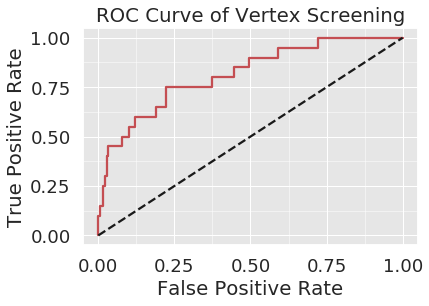

In [88]:
import seaborn as sns
import matplotlib as mpl
sns.set()
sns.set_context("talk", font_scale=1.10)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
ax.set_xticks([0, 0.125, 0.25, 0.375, 0.50, 0.625, 0.750, 0.875, 1.0], minor=True)
ax.set_yticks([0, 0.125, 0.25, 0.375, 0.50, 0.625, 0.750, 0.875, 1.0], minor=True)
plt.step(fpr_MGC, tpr_MGC, 'r', label = "MGC")
plt.title("ROC Curve of Vertex Screening")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.yticks(np.arange(0, 1.25, 0.25))
plt.xticks(np.arange(0, 1.25, 0.25))
plt.plot([0, 1], [0, 1],'k--')
print("MGC:")
print(metrics.auc(fpr_MGC, tpr_MGC))

print("ItMGC-0.05:")
plt.figure
plt.step(fpr_ItMGC_005, tpr_ItMGC_005, 'g', label = "ItMGC-0.05")
print(metrics.auc(fpr_ItMGC_005, tpr_ItMGC_005))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "Method")

Paper Results


My Results


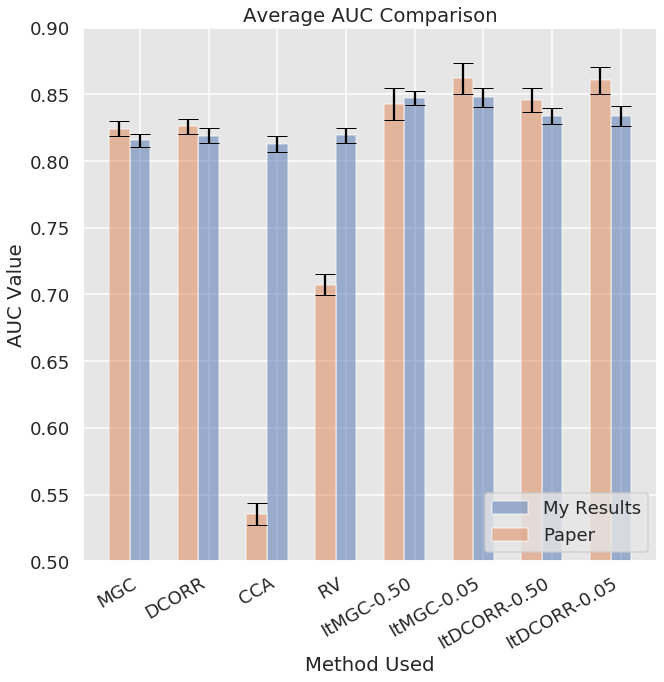

<Figure size 5000x5000 with 0 Axes>

In [72]:
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Paper Results")

fig = go.Figure(data=[go.Table(header=dict(values=['Method', 'AUC', 'Time (sec)']),
                 cells=dict(values=[['ItMGC-0.05', 'ItMGC-0.50', 'MGC'], ['0.8620 (0.0116)', '0.8425 (0.0120)', '0.8241 (0.0057)'], ['856.37 (14.45)', '110.23 (7.19)', '33.39 (1.90)']]))
                     ])
fig.show()

print("My Results")

fig2 = go.Figure(data=[go.Table(header=dict(values=['Method', 'AUC', 'Time (sec)']),
                 cells=dict(values=[['ItMGC-0.05', 'ItMGC-0.50', 'MGC'], ['0.8479 (0.0071)', '0.8418 (0.0068)', '0.8210 (0.0052)'], ['194.25', '19.97', '7.70']]))
                     ])
fig2.show()

objects = ('MGC', 'DCORR', 'CCA', 'RV', 'ItMGC-0.50', 'ItMGC-0.05', 'ItDCORR-0.50', 'ItDCORR-0.05')
x_pos = np.arange(len(objects))
means = [0.8155,0.8191,0.8125,0.8192,0.8470,0.8479,0.8336,0.8336]
pap_means = [0.8241,0.8262,0.5353,0.7074,0.8425,0.8620,0.8455,0.8605]
errs = [0.0047,0.0056,0.0061,0.0055,0.0053,0.0071,0.0061,0.0073]
pap_errs = [0.0057,0.0056,0.0080,0.0077,0.0120,0.0116,0.0091,0.0103]
w = 0.3

sns.set()
sns.set_context("talk", font_scale=1.10)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(1,1)
ax.bar(x_pos, means, yerr=errs, align='center', alpha=0.5, ecolor='black', capsize=10, width=0.3)
ax.bar(x_pos - w, pap_means, yerr=pap_errs, align='center', alpha=0.5, ecolor='black', capsize=10, width=0.3)
ax.set_ylabel('AUC Value')
ax.set_xticks(x_pos)
ax.set_xticklabels(objects)
ax.set_xlabel('Method Used')
ax.set_title('Average AUC Comparison')
ax.set_yticks([0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90], minor=True)
ax.yaxis.grid(True)
plt.ylim(top=0.90)
plt.ylim(bottom=0.50)
plt.tight_layout()
fig.autofmt_xdate()
Source=['My Results','Paper']
plt.legend(Source,loc=4)
plt.figure(num=None, figsize=(50, 50), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams["figure.figsize"] = (10,10)
fig.savefig('RESULTSFORFRI.png', bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib as mpl

prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

list_fpr_MGC = []
list_fpr_ItMGC = []

data_75, y_label_75, p_data_75 = data_generator(75, 200, n, prob_tensor, percent_vec)

SS, cors_MGC = non_iterative_screen(data_75, y_label_75, 0, "mgc")
cors_ItMGC_005 = iterative_screen(data_75, y_label_75, 20, 0.05, "mgc")





data_150, y_label_150, p_data_150 = data_generator(150, 200, n, prob_tensor, percent_vec)


data_225, y_label_225, p_data_225 = data_generator(225, 200, n, prob_tensor, percent_vec)
data_300, y_label_300, p_data_300 = data_generator(300, 200, n, prob_tensor, percent_vec)



sns.set()
sns.set_context("talk", font_scale=1.10)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
ax.set_xticks([75, 150, 225, 300], minor=True)
ax.set_yticks([0, 0.2, 0.4, 0.6], minor=True)
plt.title("Vertex False Positive Rate")
plt.ylabel("Rate")
plt.xlabel("Number of Graphs")
plt.yticks(np.arange(0, 0.8, 0.2))
plt.xticks(np.arange(75, 375, 75))

plt.figure

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "Method")